In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout, Embedding, LSTM, SpatialDropout1D, Input, Concatenate, Bidirectional
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard
from keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

In [2]:
path_to_csv = '/kaggle/input/processed-sub/processed_all_text.csv'

In [3]:
df = pd.read_csv(path_to_csv)

In [4]:
df.head()

,id,num_comments,score,upvote_ratio,all_text,hour,Class,body_len
0,x2wyl4,1.0,1.0,1.0,I can't even eat chocolate without thinking ab...,10,1,356
1,x2uv4c,1.0,1.0,1.0,How do I know he's really changing? I think th...,8,1,380
2,x2pn4w,1.0,1.0,1.0,Just got my 5th NFA 😭 This is more of a rant t...,4,1,732
3,x2p5sn,1.0,1.0,1.0,"Can't find the energy to leave Hi, I have been...",4,1,631
4,x2jeo4,1.0,1.0,1.0,Am I really at a point where I should avoid do...,0,1,2356


In [5]:
df.isna().sum()

id                 0
num_comments       0
score              0
upvote_ratio    6443
all_text           0
hour               0
Class              0
body_len           0
dtype: int64

In [6]:
df.upvote_ratio = df.upvote_ratio.fillna(1)

In [7]:
df.isna().sum()

id              0
num_comments    0
score           0
upvote_ratio    0
all_text        0
hour            0
Class           0
body_len        0
dtype: int64

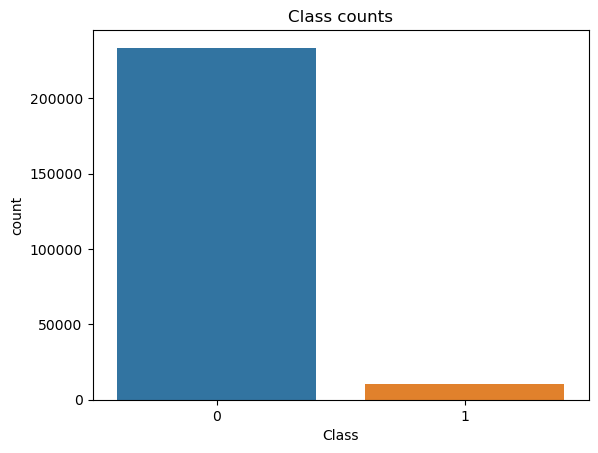

In [8]:
sns.countplot(x=df["Class"])
plt.title('Class counts')
plt.show()

In [9]:
df.Class.value_counts()

0    233426
1     10276
Name: Class, dtype: int64

In [10]:
df.Class.value_counts(normalize=True)

0    0.957834
1    0.042166
Name: Class, dtype: float64

In [11]:
weight_for_0 = 1/df.Class.value_counts()[0]
weight_for_1 = 1/df.Class.value_counts()[1]
print(weight_for_0)
print(weight_for_1)

4.284012920582968e-06
9.731413001167769e-05


#### choose max sequence length for LSTM

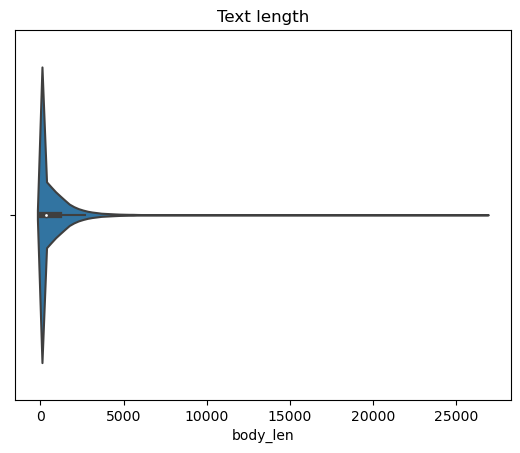

In [12]:
sns.violinplot(x=df['body_len'])
plt.title('Text length')
plt.show()

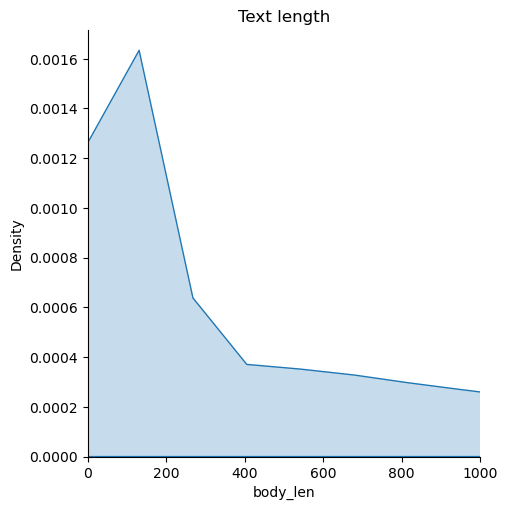

In [13]:
sns.displot(x=df['body_len'], kind='kde', fill=True)
plt.xlim([0, 1000])
plt.title('Text length')
plt.show()

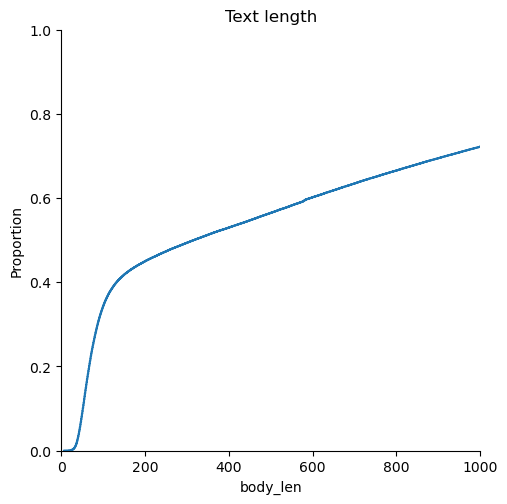

In [14]:
sns.displot(x=df['body_len'], kind='ecdf')
plt.xlim([0, 1000])
plt.title('Text length')
plt.show()

we choose 500 as hour max sequence length

In [15]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH =500
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['all_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 158300 unique tokens.


In [16]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=25)
train_data, val_data= train_test_split(train_data, test_size=0.2, random_state=25)
train_data.shape, val_data.shape, test_data.shape

((175464, 8), (43867, 8), (24371, 8))

In [17]:
X_train_num=train_data.drop(['id','Class','all_text'],axis=1)
X_train_text=train_data['all_text']
y_train = train_data.Class

X_val_num=val_data.drop(['id','Class','all_text'],axis=1)
X_val_text=val_data['all_text']
y_val = val_data.Class

X_test_num=test_data.drop(['id','Class','all_text'],axis=1)
X_test_text=test_data['all_text']
y_test = test_data.Class

In [18]:
X_train_text.shape, X_val_text.shape,X_test_text.shape

((175464,), (43867,), (24371,))

In [19]:
X_train_num.shape,X_val_num.shape, X_test_num.shape

((175464, 5), (43867, 5), (24371, 5))

In [20]:
#create sequences for vinila LSTM model
X_vect_train = tokenizer.texts_to_sequences(X_train_text.values)
X_vect_train = pad_sequences(X_vect_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of X_train data tensor:', X_vect_train.shape)

X_vect_val = tokenizer.texts_to_sequences(X_val_text.values)
X_vect_val = pad_sequences(X_vect_val, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of X_val data tensor:', X_vect_val.shape)

X_vect_test = tokenizer.texts_to_sequences(X_test_text.values)
X_vect_test = pad_sequences(X_vect_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of X_test data tensor:', X_vect_test.shape)

Shape of X_train data tensor: (175464, 500)
Shape of X_val data tensor: (43867, 500)
Shape of X_test data tensor: (24371, 500)


In [21]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

CALLBACKS=[EarlyStopping(monitor='val_prc', verbose=1,patience=3, mode='max',restore_best_weights=True)]

EPOCHS = 20
# NUM_TRAIN_STEPS = len(train_data) * EPOCHS
# lr_scheduler = PolynomialDecay(
#     initial_learning_rate=1e-2,
#     end_learning_rate=0.,
#     decay_steps=NUM_TRAIN_STEPS)
# OPTIMIZER= Adam(learning_rate=lr_scheduler)


In [22]:
modelV0 = keras.models.load_model('/kaggle/input/lstm-models-8th/LSTM_model_V0_no_weightsmodel.h5')
modelV1 = keras.models.load_model('/kaggle/input/lstm-models-8th/LSTM_model_V1_class_weight.h5')
modelV2 = keras.models.load_model('/kaggle/input/lstm-models-8th/LSTM_model_V2_numeric_class_weight.h5')
modelV3 = keras.models.load_model('/kaggle/input/lstm-models-8th/LSTM_model_V3_undersampling.h5')
modelV6 = keras.models.load_model('/kaggle/input/lstm-models-8th/LSTM_model_V6_oversampling.h5')

### Create a base model with just text and no class weights

In [59]:
modelV0 = Sequential()
modelV0.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_vect_train.shape[1]))
modelV0.add(SpatialDropout1D(0.2))
modelV0.add(LSTM(100, dropout=0.2, recurrent_dropout=0))
modelV0.add(Dense(4, activation='relu'))
modelV0.add(Dense(1, activation='sigmoid'))
modelV0.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=METRICS)
print(modelV0.summary())

Model: "sequential_3"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding_4 (Embedding)     (None, 500, 100)          5000000   

                                                                 

 spatial_dropout1d_4 (Spatia  (None, 500, 100)         0         

 lDropout1D)                                                     

                                                                 

 lstm_4 (LSTM)               (None, 100)               80400     

                                                                 

 dense_8 (Dense)             (None, 4)                 404       

                                                                 

 dense_9 (Dense)             (None, 1)                 5         

                                                                 


Total params: 5,080,809

Trainable params: 5,080,809

Non-trainable params: 0

_________________________

In [60]:
historyV0 = modelV0.fit(
    X_vect_train, 
    y_train,
    batch_size=32,
    epochs=EPOCHS,
    validation_data=(X_vect_val, y_val),
    callbacks=CALLBACKS)

Epoch 1/20

5484/5484 [==============================] - 221s 40ms/step - loss: 0.1258 - tp: 2207.0000 - fp: 787.0000 - tn: 167252.0000 - fn: 5218.0000 - accuracy: 0.9658 - precision: 0.7371 - recall: 0.2972 - auc: 0.8379 - prc: 0.4160 - val_loss: 0.0722 - val_tp: 1050.0000 - val_fp: 191.0000 - val_tn: 41864.0000 - val_fn: 762.0000 - val_accuracy: 0.9783 - val_precision: 0.8461 - val_recall: 0.5795 - val_auc: 0.9528 - val_prc: 0.7520

Epoch 2/20

5484/5484 [==============================] - 153s 28ms/step - loss: 0.0696 - tp: 4867.0000 - fp: 1302.0000 - tn: 166737.0000 - fn: 2558.0000 - accuracy: 0.9780 - precision: 0.7889 - recall: 0.6555 - auc: 0.9574 - prc: 0.7448 - val_loss: 0.0601 - val_tp: 1284.0000 - val_fp: 281.0000 - val_tn: 41774.0000 - val_fn: 528.0000 - val_accuracy: 0.9816 - val_precision: 0.8204 - val_recall: 0.7086 - val_auc: 0.9654 - val_prc: 0.8067

Epoch 3/20

5484/5484 [==============================] - 148s 27ms/step - loss: 0.0618 - tp: 5135.0000 - fp: 1237.0000 - 

In [61]:
modelV0.save('LSTM_model_V0_no_weightsmodel.h5')

In [23]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)

In [24]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

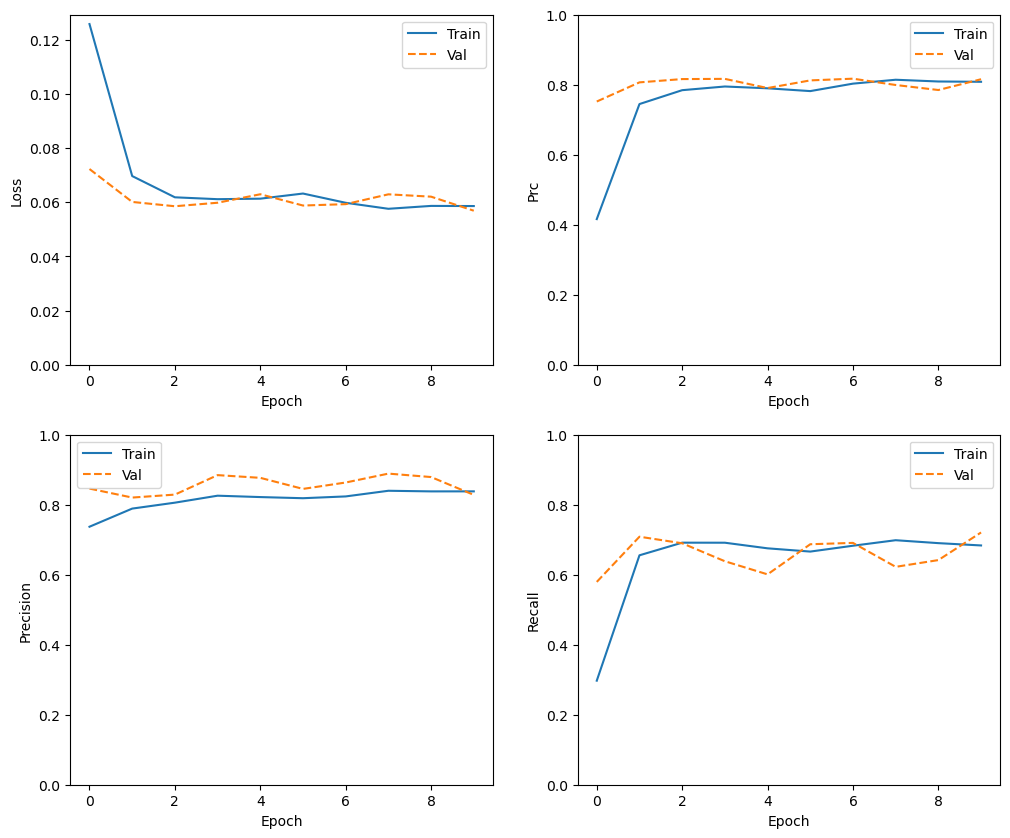

In [64]:
plot_metrics(historyV0)

In [65]:
### create confusion matrix to summarize the actual vs. predicted labels

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  group_names = ['TN','FP','FN','TP']
  group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
  labels = np.asarray(labels).reshape(2,2)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=labels, fmt='', cmap='Blues');
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('non_dv posts Detected (True Negatives): ', cm[0][0])
  print('non_dv posts Incorrectly Detected (False Positives): ', cm[0][1])
  print('dv posts Missed (False Negatives): ', cm[1][0])
  print('dv posts Detected (True Positives): ', cm[1][1])
  print('Total dv posts: ', np.sum(cm[1]))

5484/5484 [==============================] - 41s 7ms/step

762/762 [==============================] - 6s 8ms/step

non_dv posts Detected (True Negatives):  23205

non_dv posts Incorrectly Detected (False Positives):  127

dv posts Missed (False Negatives):  311

dv posts Detected (True Positives):  728

Total dv posts:  1039


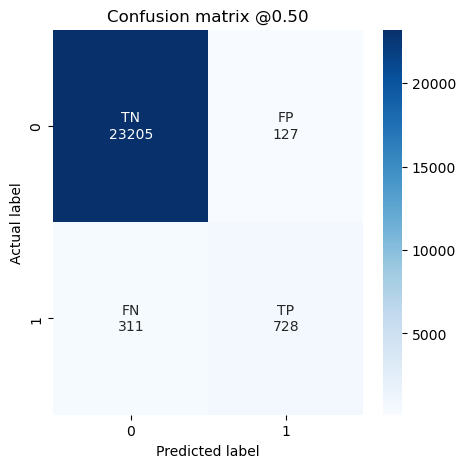

In [66]:
train_predictions_modelV0 = modelV0.predict(X_vect_train, batch_size=32)
test_predictions_modelV0 = modelV0.predict(X_vect_test, batch_size=32)

plot_cm(y_test, test_predictions_modelV0)

In [25]:
test_predictions_modelV0 = modelV0.predict(X_vect_test, batch_size=32)
test_predictions_modelV0

762/762 [==============================] - 11s 8ms/step


array([[2.9700805e-04],
       [1.4365738e-04],
       [4.1732931e-04],
       ...,
       [3.1263491e-03],
       [7.5561504e-05],
       [2.5916565e-04]], dtype=float32)

In [26]:
predict_classes_V0=(test_predictions_modelV0 > 0.5).astype("int32")
predict_classes_V0

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [27]:
from sklearn.metrics import classification_report
print("modelV0 Classification report:\n\n{}".format(classification_report(y_test, predict_classes_V0)))

modelV0 Classification report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23332
           1       0.85      0.70      0.77      1039

    accuracy                           0.98     24371
   macro avg       0.92      0.85      0.88     24371
weighted avg       0.98      0.98      0.98     24371



In [28]:
# Plot the AUPRC
import sklearn
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

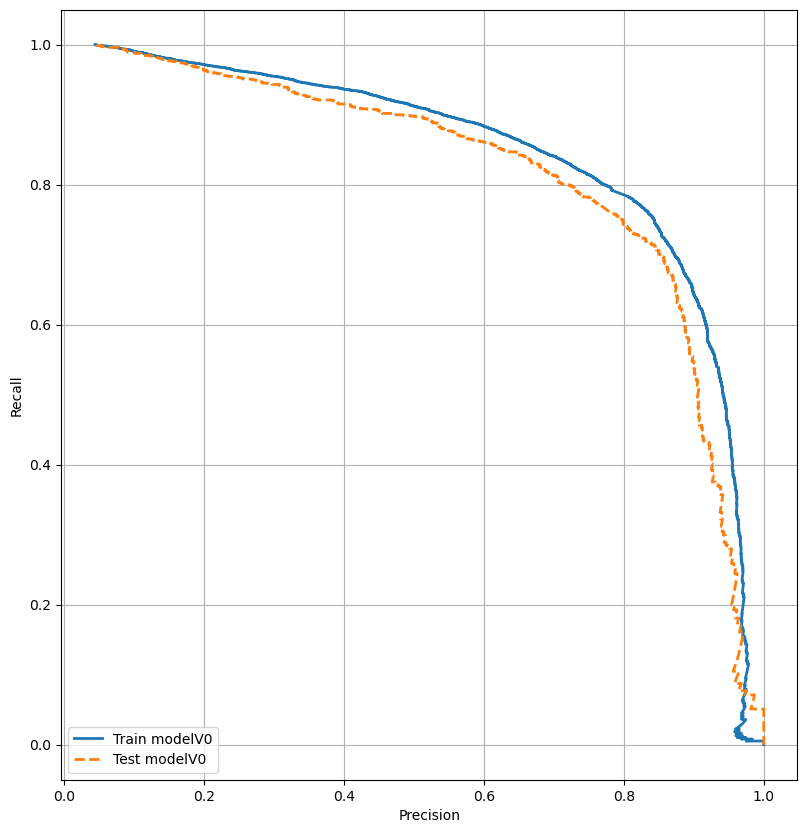

In [71]:
plot_prc("Train modelV0", y_train, train_predictions_modelV0)
plot_prc("Test modelV0", y_test, test_predictions_modelV0,linestyle='--')
plt.legend(loc='lower left');

### Create model with just text feature and class weights

In [34]:
modelV1 = Sequential()
modelV1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_vect_train.shape[1]))
modelV1.add(SpatialDropout1D(0.2))
modelV1.add(LSTM(100, dropout=0.2, recurrent_dropout=0))
modelV1.add(Dense(4, activation='relu'))
modelV1.add(Dense(1, activation='sigmoid'))
modelV1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=METRICS)
print(modelV1.summary())

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding_1 (Embedding)     (None, 500, 100)          5000000   

                                                                 

 spatial_dropout1d_1 (Spatia  (None, 500, 100)         0         

 lDropout1D)                                                     

                                                                 

 lstm_1 (LSTM)               (None, 100)               80400     

                                                                 

 dense_3 (Dense)             (None, 1)                 101       

                                                                 


Total params: 5,080,501

Trainable params: 5,080,501

Non-trainable params: 0

_________________________________________________________________

None


In [35]:
CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}

historyV1 = modelV1.fit(
    X_vect_train, 
    y_train,
    batch_size=32,
    epochs=EPOCHS,
    validation_data=(X_vect_val, y_val),
    class_weight=CLASS_WEIGHT,
    callbacks=CALLBACKS)

Epoch 1/20

5484/5484 [==============================] - 275s 50ms/step - loss: 4.1543e-06 - tp: 7629.0000 - fp: 54474.0000 - tn: 155620.0000 - fn: 1608.0000 - accuracy: 0.7443 - precision: 0.1228 - recall: 0.8259 - auc: 0.8745 - prc: 0.3608 - val_loss: 0.1306 - val_tp: 1542.0000 - val_fp: 1670.0000 - val_tn: 40385.0000 - val_fn: 270.0000 - val_accuracy: 0.9558 - val_precision: 0.4801 - val_recall: 0.8510 - val_auc: 0.9689 - val_prc: 0.7275

Epoch 2/20

5484/5484 [==============================] - 158s 29ms/step - loss: 1.3841e-06 - tp: 6965.0000 - fp: 10694.0000 - tn: 157345.0000 - fn: 460.0000 - accuracy: 0.9364 - precision: 0.3944 - recall: 0.9380 - auc: 0.9814 - prc: 0.7837 - val_loss: 0.1810 - val_tp: 1755.0000 - val_fp: 2880.0000 - val_tn: 39175.0000 - val_fn: 57.0000 - val_accuracy: 0.9330 - val_precision: 0.3786 - val_recall: 0.9685 - val_auc: 0.9894 - val_prc: 0.8387

Epoch 3/20

5484/5484 [==============================] - 144s 26ms/step - loss: 8.4254e-07 - tp: 7199.0000 - f

In [72]:
modelV1.save('LSTM_model_V1_class_weight.h5')

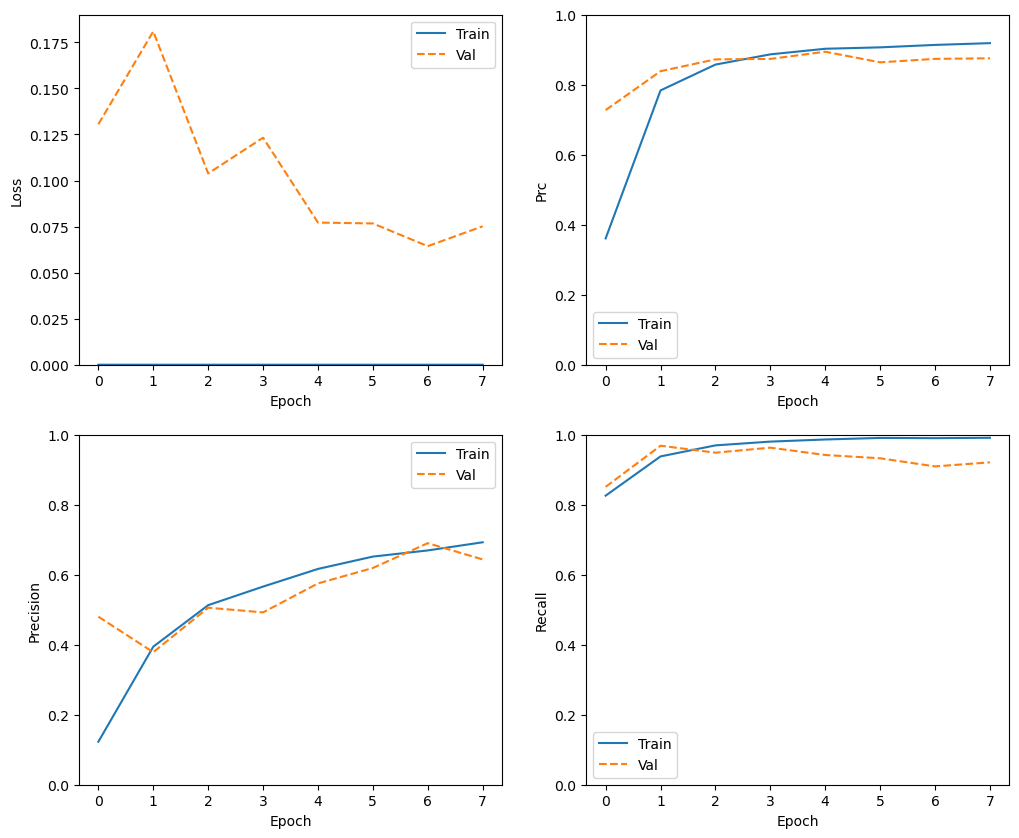

In [80]:
plot_metrics(historyV1)

In [29]:
test_predictions_modelV1 = modelV1.predict(X_vect_test, batch_size=32)

762/762 [==============================] - 6s 8ms/step


non_dv posts Detected (True Negatives):  22617

non_dv posts Incorrectly Detected (False Positives):  715

dv posts Missed (False Negatives):  62

dv posts Detected (True Positives):  977

Total dv posts:  1039


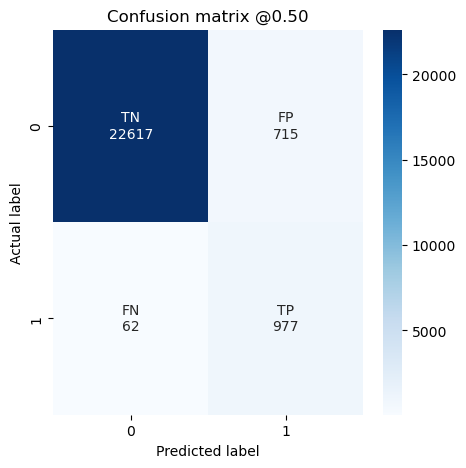

In [42]:
plot_cm(y_test, test_predictions_modelV1)

In [30]:
predict_classes_V1=(test_predictions_modelV1 > 0.5).astype("int32")
print("ModelV1 Classification report:\n\n{}".format(classification_report(y_test, predict_classes_V1)))

ModelV1 Classification report:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     23332
           1       0.58      0.94      0.72      1039

    accuracy                           0.97     24371
   macro avg       0.79      0.95      0.85     24371
weighted avg       0.98      0.97      0.97     24371



It is interesting that with specified class_weights, which adjust inversely proportional to class frequencies in the input data, improved the recall significantly but reduced the precision significantly as well.

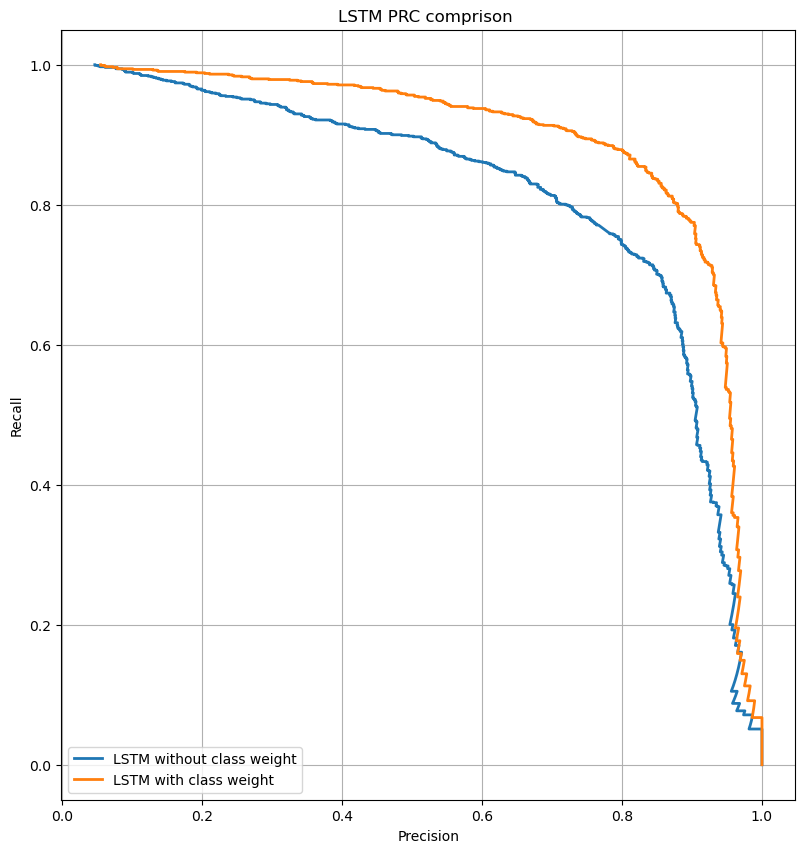

In [73]:
plot_prc("LSTM without class weight", y_test, test_predictions_modelV0 )
plot_prc("LSTM with class weight", y_test, test_predictions_modelV1)
plt.legend(loc='lower left');
plt.title('LSTM PRC comprison ')
plt.show()

class weights does help model performance

### Create a model including numeric features

In [31]:
def LSTM_model(optimizer,X_text_train, X_num_train):
    # Define the text flow
    embedding_layer =(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_text_train.shape[1]))
    input_text = keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int64")
    embedded_sequences = embedding_layer(input_text)
    x=SpatialDropout1D(0.2)(embedded_sequences)
    x = layers.LSTM(100, dropout=0.2, recurrent_dropout=0)(x)   
    x = Model(inputs=input_text, outputs=x)

    # Define the num flow
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(X_num_train)
    input_num = layers.Input(shape=(5,))
    y = normalizer(input_num)
    y = layers.Dense(10, activation="relu")(y)
    y = Model(inputs=input_num, outputs=y)   

    # Concatenate the two streams together
    combined = layers.concatenate([x.output, y.output])

    # Define joined Feed-Forward Layer
    z = layers.Dense(4, activation="relu")(combined)
    # Define output node of 1 
    z = layers.Dense(1, activation="sigmoid")(z)

    # Define the final model
    model=Model(inputs=[x.input, y.input], outputs=z)
    
    model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)
    return model

In [82]:
optimizer = Adam(learning_rate=0.01)
modelV2= LSTM_model(optimizer=optimizer, X_text_train=X_vect_train, X_num_train=X_train_num)
print(modelV2.summary())

Model: "model_8"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_5 (InputLayer)           [(None, 500)]        0           []                               

                                                                                                  

 embedding_6 (Embedding)        (None, 500, 100)     5000000     ['input_5[0][0]']                

                                                                                                  

 input_6 (InputLayer)           [(None, 5)]          0           []                               

                                                                                                  

 spatial_dropout1d_6 (SpatialDr  (None, 500, 100)    0           ['embedding_6[0][0]']            

 opout1D)                                                                        

In [83]:
CALLBACKS=[EarlyStopping(monitor='val_prc', verbose=1,patience=3, mode='max',restore_best_weights=True)]

historyV2 = modelV2.fit(
    x=[X_vect_train, X_train_num],
    y=y_train, 
    validation_data=([X_vect_val, X_val_num],y_val),
    batch_size=32,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT,
    callbacks=CALLBACKS)

Epoch 1/20

5484/5484 [==============================] - 245s 44ms/step - loss: 4.4205e-06 - tp: 7876.0000 - fp: 75059.0000 - tn: 135035.0000 - fn: 1361.0000 - accuracy: 0.6516 - precision: 0.0950 - recall: 0.8527 - auc: 0.8169 - prc: 0.2439 - val_loss: 0.4024 - val_tp: 1500.0000 - val_fp: 9000.0000 - val_tn: 33055.0000 - val_fn: 312.0000 - val_accuracy: 0.7877 - val_precision: 0.1429 - val_recall: 0.8278 - val_auc: 0.8908 - val_prc: 0.2844

Epoch 2/20

5484/5484 [==============================] - 150s 27ms/step - loss: 2.7166e-06 - tp: 6551.0000 - fp: 31048.0000 - tn: 136991.0000 - fn: 874.0000 - accuracy: 0.8181 - precision: 0.1742 - recall: 0.8823 - auc: 0.9315 - prc: 0.5637 - val_loss: 0.0867 - val_tp: 1624.0000 - val_fp: 1019.0000 - val_tn: 41036.0000 - val_fn: 188.0000 - val_accuracy: 0.9725 - val_precision: 0.6145 - val_recall: 0.8962 - val_auc: 0.9856 - val_prc: 0.8787

Epoch 3/20

5484/5484 [==============================] - 143s 26ms/step - loss: 1.0433e-06 - tp: 7096.0000 - 

In [85]:
modelV2.save('LSTM_model_V2_numeric_class_weight.h5')

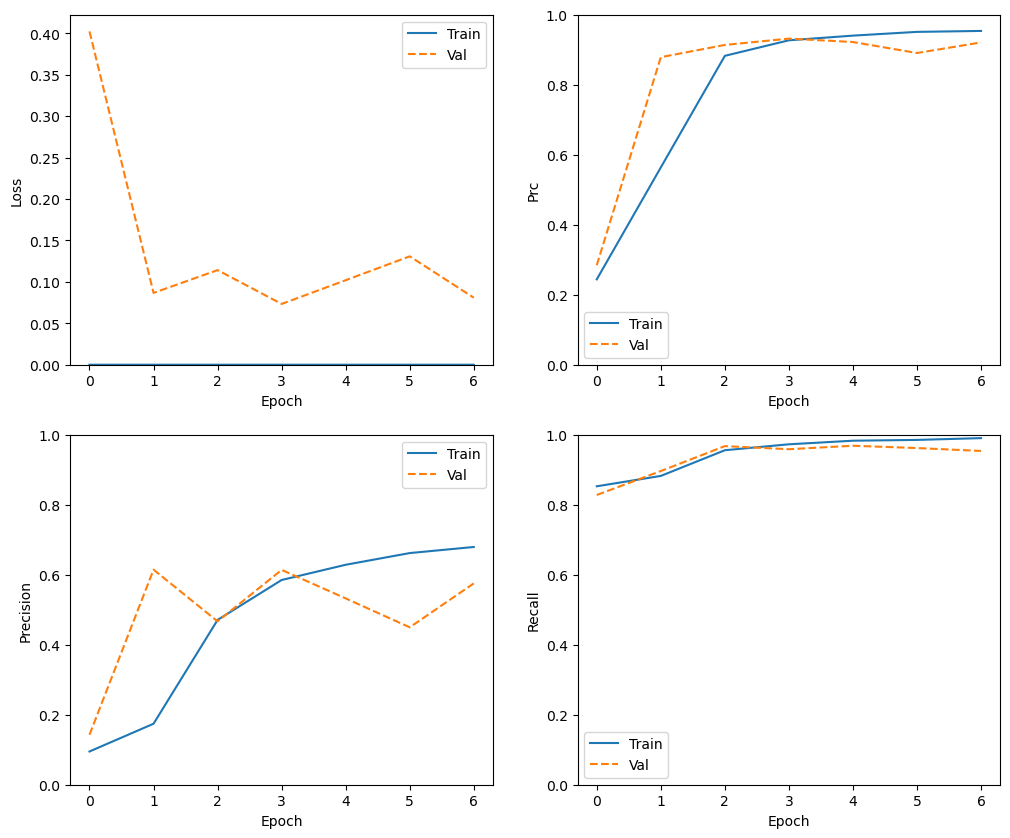

In [86]:
plot_metrics(historyV2)

In [32]:
test_predictions_modelV2 = modelV2.predict([X_vect_test, X_test_num], batch_size=32)

762/762 [==============================] - 7s 8ms/step


In [33]:
predict_classes_V2=(test_predictions_modelV2 > 0.5).astype("int32")

In [34]:
print("ModelV2 Classification report:\n\n{}".format(classification_report(y_test, predict_classes_V2)))

ModelV2 Classification report:

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     23332
           1       0.62      0.96      0.75      1039

    accuracy                           0.97     24371
   macro avg       0.81      0.97      0.87     24371
weighted avg       0.98      0.97      0.98     24371



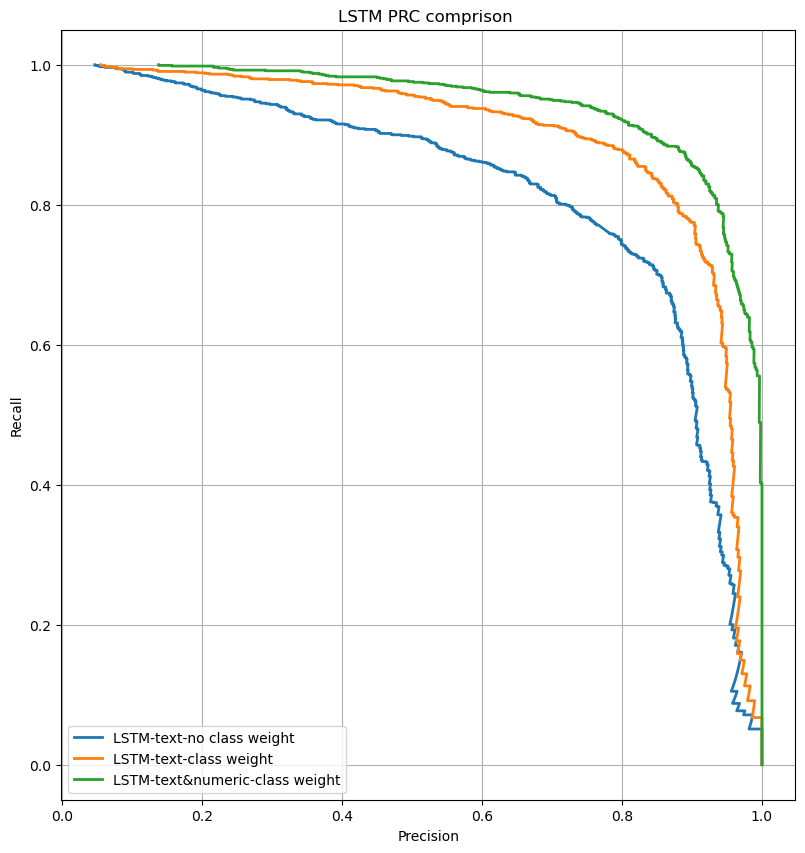

In [91]:
plot_prc("LSTM-text-no class weight", y_test, test_predictions_modelV0 )
plot_prc("LSTM-text-class weight", y_test, test_predictions_modelV1)
plot_prc("LSTM-text&numeric-class weight", y_test, test_predictions_modelV2)
plt.legend(loc='lower left');
plt.title('LSTM PRC comprison ')
plt.show()

adding numeric features helped!

### try undersampling method-- with text&numeric and class weights

In [35]:
# Class count
count_class_0, count_class_1 = train_data.Class.value_counts()

# Divide by class
df_class_0 = train_data[train_data['Class'] == 0]
df_class_1 = train_data[train_data['Class'] == 1]
count_class_0, count_class_1

(168039, 7425)

In [36]:
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_under.Class.value_counts())

Random under-sampling:
0    7425
1    7425
Name: Class, dtype: int64


In [37]:
X_train_under_num=df_under.drop(['id','Class','all_text'],axis=1)
X_train_under_text=df_under['all_text']
y_train_under = df_under.Class

X_train_under_num.shape, X_train_under_text.shape, y_train_under.shape

((14850, 5), (14850,), (14850,))

In [38]:
X_vect_train_under = tokenizer.texts_to_sequences(X_train_under_text.values)
X_vect_train_under = pad_sequences(X_vect_train_under, maxlen=MAX_SEQUENCE_LENGTH)

In [41]:
optimizer = Adam(learning_rate=0.01)
modelV3= LSTM_model(optimizer=optimizer, X_text_train=X_vect_train_under, X_num_train=X_train_under_num)
print(modelV3.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 100)     5000000     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 500, 100)    0           ['embedding[0][0]']              
 out1D)                                                                                     

In [50]:
CALLBACKS=[EarlyStopping(monitor='val_prc', verbose=1,patience=5, mode='max',restore_best_weights=True)]

historyV3 = modelV3.fit(
    x=[X_vect_train_under, X_train_under_num],
    y=y_train_under, 
    validation_data=([X_vect_val, X_val_num],y_val),
    batch_size=32,
    epochs=EPOCHS,
    callbacks=CALLBACKS)

Epoch 1/20
465/465 [==============================] - 26s 57ms/step - loss: 0.6934 - tp: 3974.0000 - fp: 3962.0000 - tn: 3463.0000 - fn: 3451.0000 - accuracy: 0.5008 - precision: 0.5008 - recall: 0.5352 - auc: 0.4978 - prc: 0.4965 - val_loss: 0.6725 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 42055.0000 - val_fn: 1812.0000 - val_accuracy: 0.9587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0413
Epoch 2/20
465/465 [==============================] - 36s 76ms/step - loss: 0.6934 - tp: 3787.0000 - fp: 3925.0000 - tn: 3500.0000 - fn: 3638.0000 - accuracy: 0.4907 - precision: 0.4911 - recall: 0.5100 - auc: 0.4913 - prc: 0.4936 - val_loss: 0.6879 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 42055.0000 - val_fn: 1812.0000 - val_accuracy: 0.9587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0413
Epoch 3/20
465/465 [==============================] - 25s 53ms/step - loss: 0.6933 - tp: 4141.0000 - fp: 4146.

the model is not leanringa at all.

### try with example weight

In [43]:
example_weight=count_class_0/ count_class_1
example_weight

22.631515151515153

In [44]:
EXAMPLE_WEIGHT= {0: example_weight, 1: 1}

In [45]:
optimizer = Adam(learning_rate=0.01)
modelV4= LSTM_model(optimizer=optimizer, X_text_train=X_vect_train_under, X_num_train=X_train_under_num)
print(modelV4.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 500, 100)     5000000     ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 500, 100)    0           ['embedding_1[0][0]']            
 opout1D)                                                                                   

In [46]:
CALLBACKS=[EarlyStopping(monitor='val_prc', verbose=1,patience=5, mode='max',restore_best_weights=True)]

historyV4 = modelV4.fit(
    x=[X_vect_train_under, X_train_under_num],
    y=y_train_under, 
    validation_data=([X_vect_val, X_val_num],y_val),
    batch_size=32,
    epochs=EPOCHS,
    class_weight=EXAMPLE_WEIGHT,
    callbacks=CALLBACKS)

Epoch 1/20
465/465 [==============================] - 74s 152ms/step - loss: 1.5192 - tp: 1339.0000 - fp: 20.0000 - tn: 49460.0000 - fn: 7898.0000 - accuracy: 0.8651 - precision: 0.9853 - recall: 0.1450 - auc: 0.3473 - prc: 0.2606 - val_loss: 0.0668 - val_tp: 988.0000 - val_fp: 210.0000 - val_tn: 41845.0000 - val_fn: 824.0000 - val_accuracy: 0.9764 - val_precision: 0.8247 - val_recall: 0.5453 - val_auc: 0.9749 - val_prc: 0.7791
Epoch 2/20
465/465 [==============================] - 47s 101ms/step - loss: 0.6002 - tp: 5464.0000 - fp: 52.0000 - tn: 7373.0000 - fn: 1961.0000 - accuracy: 0.8644 - precision: 0.9906 - recall: 0.7359 - auc: 0.9765 - prc: 0.9814 - val_loss: 0.0552 - val_tp: 1473.0000 - val_fp: 443.0000 - val_tn: 41612.0000 - val_fn: 339.0000 - val_accuracy: 0.9822 - val_precision: 0.7688 - val_recall: 0.8129 - val_auc: 0.9793 - val_prc: 0.8650
Epoch 3/20
465/465 [==============================] - 31s 66ms/step - loss: 0.3783 - tp: 6255.0000 - fp: 25.0000 - tn: 7400.0000 - fn: 1

In [47]:
modelV4.save('LSTM_model_V4_undersampling_example_weight.h5')

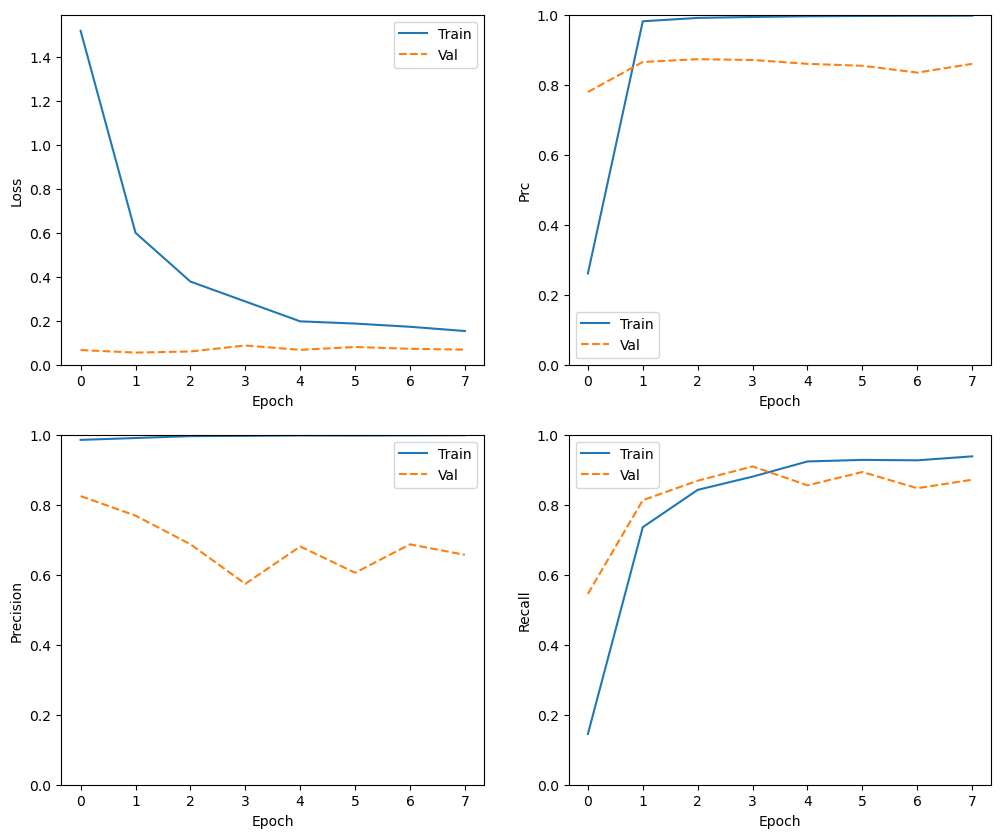

In [48]:
plot_metrics(historyV4)

In [49]:
test_predictions_modelV4 = modelV4.predict([X_vect_test, X_test_num], batch_size=32)
predict_classes_V4=(test_predictions_modelV4 > 0.5).astype("int32")
print("ModelV4 Classification report:\n\n{}".format(classification_report(y_test, predict_classes_V4)))

762/762 [==============================] - 6s 8ms/step
ModelV4 Classification report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     23332
           1       0.70      0.89      0.78      1039

    accuracy                           0.98     24371
   macro avg       0.85      0.94      0.88     24371
weighted avg       0.98      0.98      0.98     24371



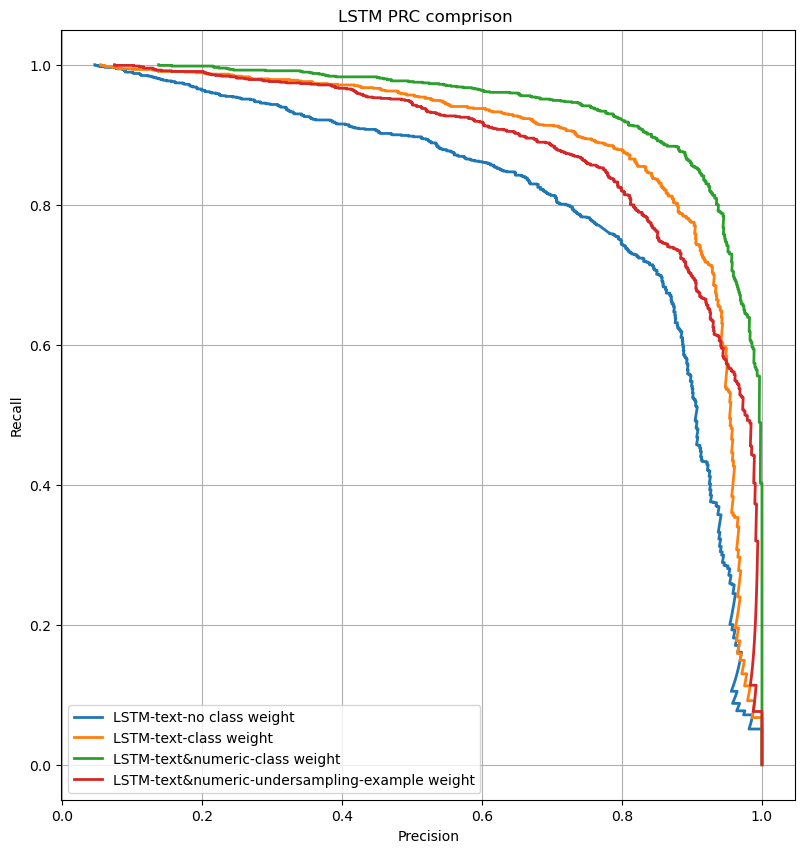

In [51]:
plot_prc("LSTM-text-no class weight", y_test, test_predictions_modelV0 )
plot_prc("LSTM-text-class weight", y_test, test_predictions_modelV1)
plot_prc("LSTM-text&numeric-class weight", y_test, test_predictions_modelV2)
plot_prc("LSTM-text&numeric-undersampling-example weight", y_test, test_predictions_modelV4)

plt.legend(loc='lower left');
plt.title('LSTM PRC comprison ')
plt.show()

### modelV5--undersampling -with class weights

In [107]:
optimizer = Adam(learning_rate=0.01)
modelV5= LSTM_model(optimizer=optimizer, X_text_train=X_vect_train_under, X_num_train=X_train_under_num)
print(modelV5.summary())

Model: "model_14"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_9 (InputLayer)           [(None, 500)]        0           []                               

                                                                                                  

 embedding_8 (Embedding)        (None, 500, 100)     5000000     ['input_9[0][0]']                

                                                                                                  

 input_10 (InputLayer)          [(None, 5)]          0           []                               

                                                                                                  

 spatial_dropout1d_8 (SpatialDr  (None, 500, 100)    0           ['embedding_8[0][0]']            

 opout1D)                                                                       

In [108]:
CALLBACKS=[EarlyStopping(monitor='val_prc', verbose=1,patience=3, mode='max',restore_best_weights=True)]
historyV5 = modelV5.fit(
    x=[X_vect_train_under, X_train_under_num],
    y=y_train_under, 
    validation_data=([X_vect_val, X_val_num],y_val),
    batch_size=32,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT,
    callbacks=CALLBACKS)

Epoch 1/20

465/465 [==============================] - 61s 122ms/step - loss: 9.3566e-06 - tp: 9053.0000 - fp: 8438.0000 - tn: 41042.0000 - fn: 184.0000 - accuracy: 0.8532 - precision: 0.5176 - recall: 0.9801 - auc: 0.9429 - prc: 0.7001 - val_loss: 2.7889 - val_tp: 1812.0000 - val_fp: 42055.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0413 - val_precision: 0.0413 - val_recall: 1.0000 - val_auc: 0.7680 - val_prc: 0.1149

Epoch 2/20

465/465 [==============================] - 36s 78ms/step - loss: 7.2485e-06 - tp: 7425.0000 - fp: 7422.0000 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 0.5002 - precision: 0.5001 - recall: 1.0000 - auc: 0.8088 - prc: 0.7854 - val_loss: 2.1669 - val_tp: 1812.0000 - val_fp: 42049.0000 - val_tn: 6.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0414 - val_precision: 0.0413 - val_recall: 1.0000 - val_auc: 0.8840 - val_prc: 0.2659

Epoch 3/20

465/465 [==============================] - 38s 82ms/step - loss: 6.1305e-06 - tp: 7425.0000 - fp: 7284.0000

the model is not leanring as all

### oversampling

### modelV6--oversampling without class weight

In [56]:
# Oversample 1-class and concat the DataFrames of both classes
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.Class.value_counts())

Random over-sampling:
0    168039
1    168039
Name: Class, dtype: int64


In [57]:
X_train_over_num=df_over.drop(['id','Class','all_text'],axis=1)
X_train_over_text=df_over['all_text']
y_train_over = df_over.Class

X_train_over_num.shape, X_train_over_text.shape, y_train_over.shape

((336078, 5), (336078,), (336078,))

In [58]:
X_vect_train_over = tokenizer.texts_to_sequences(X_train_over_text.values)
X_vect_train_over = pad_sequences(X_vect_train_over, maxlen=MAX_SEQUENCE_LENGTH)

In [112]:
optimizer = Adam(learning_rate=0.01)
modelV6= LSTM_model(optimizer=optimizer, X_text_train=X_vect_train_over, X_num_train=X_train_over_num)
print(modelV6.summary())

Model: "model_17"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_11 (InputLayer)          [(None, 500)]        0           []                               

                                                                                                  

 embedding_9 (Embedding)        (None, 500, 100)     5000000     ['input_11[0][0]']               

                                                                                                  

 input_12 (InputLayer)          [(None, 5)]          0           []                               

                                                                                                  

 spatial_dropout1d_9 (SpatialDr  (None, 500, 100)    0           ['embedding_9[0][0]']            

 opout1D)                                                                       

In [113]:
CALLBACKS=[EarlyStopping(monitor='val_prc', verbose=1,patience=3, mode='max',restore_best_weights=True)]

historyV6 = modelV6.fit(
    x=[X_vect_train_over, X_train_over_num],
    y=y_train_over, 
    validation_data=([X_vect_val, X_val_num],y_val),
    batch_size=32,
    epochs=EPOCHS,
    callbacks=CALLBACKS)

Epoch 1/20

10503/10503 [==============================] - 337s 32ms/step - loss: 0.0813 - tp: 165587.0000 - fp: 47850.0000 - tn: 162244.0000 - fn: 4264.0000 - accuracy: 0.8628 - precision: 0.7758 - recall: 0.9749 - auc: 0.9680 - prc: 0.9654 - val_loss: 0.0684 - val_tp: 1664.0000 - val_fp: 909.0000 - val_tn: 41146.0000 - val_fn: 148.0000 - val_accuracy: 0.9759 - val_precision: 0.6467 - val_recall: 0.9183 - val_auc: 0.9855 - val_prc: 0.9093

Epoch 2/20

10503/10503 [==============================] - 263s 25ms/step - loss: 0.0541 - tp: 165639.0000 - fp: 3819.0000 - tn: 164220.0000 - fn: 2400.0000 - accuracy: 0.9815 - precision: 0.9775 - recall: 0.9857 - auc: 0.9975 - prc: 0.9970 - val_loss: 0.0611 - val_tp: 1644.0000 - val_fp: 743.0000 - val_tn: 41312.0000 - val_fn: 168.0000 - val_accuracy: 0.9792 - val_precision: 0.6887 - val_recall: 0.9073 - val_auc: 0.9774 - val_prc: 0.9015

Epoch 3/20

10503/10503 [==============================] - 256s 24ms/step - loss: 0.0487 - tp: 166020.0000 - fp

In [115]:
modelV6.save('LSTM_model_V6_oversampling.h5')

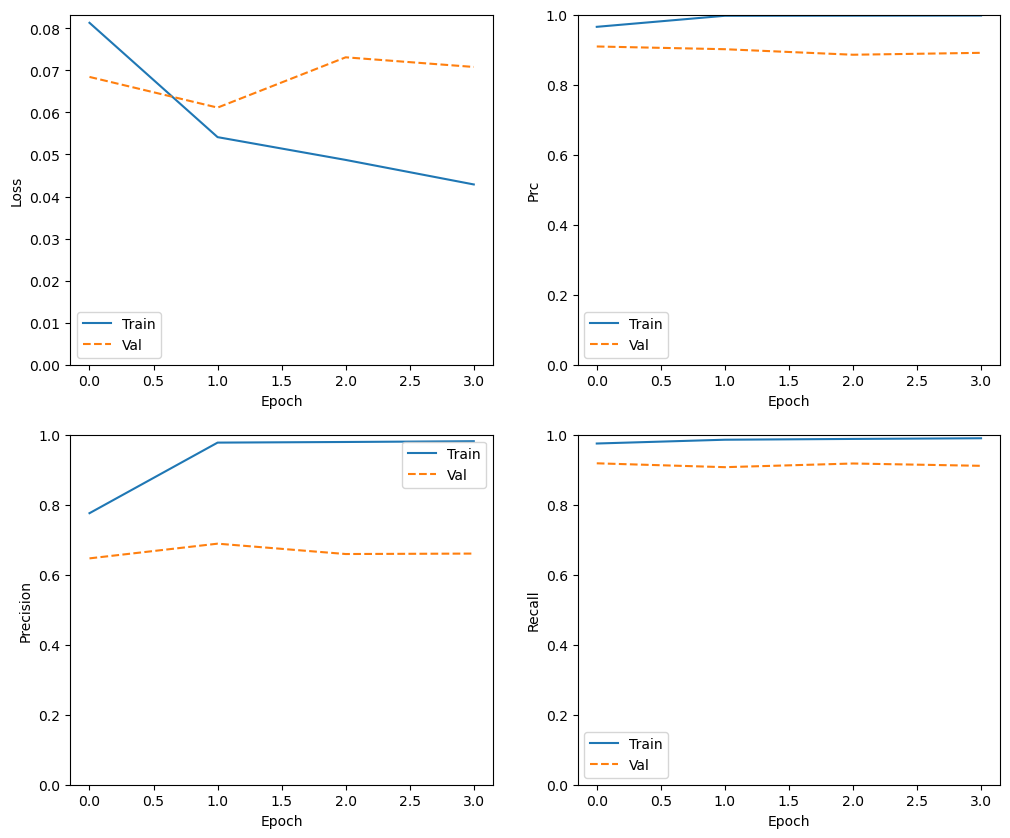

In [116]:
plot_metrics(historyV6)

seemsl like the 

In [53]:
test_predictions_modelV6 = modelV6.predict([X_vect_test, X_test_num], batch_size=32)
predict_classes_V6=(test_predictions_modelV6 > 0.5).astype("int32")
print("ModelV6 Classification report:\n\n{}".format(classification_report(y_test, predict_classes_V6)))

762/762 [==============================] - 7s 9ms/step
ModelV6 Classification report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     23332
           1       0.66      0.94      0.77      1039

    accuracy                           0.98     24371
   macro avg       0.83      0.96      0.88     24371
weighted avg       0.98      0.98      0.98     24371



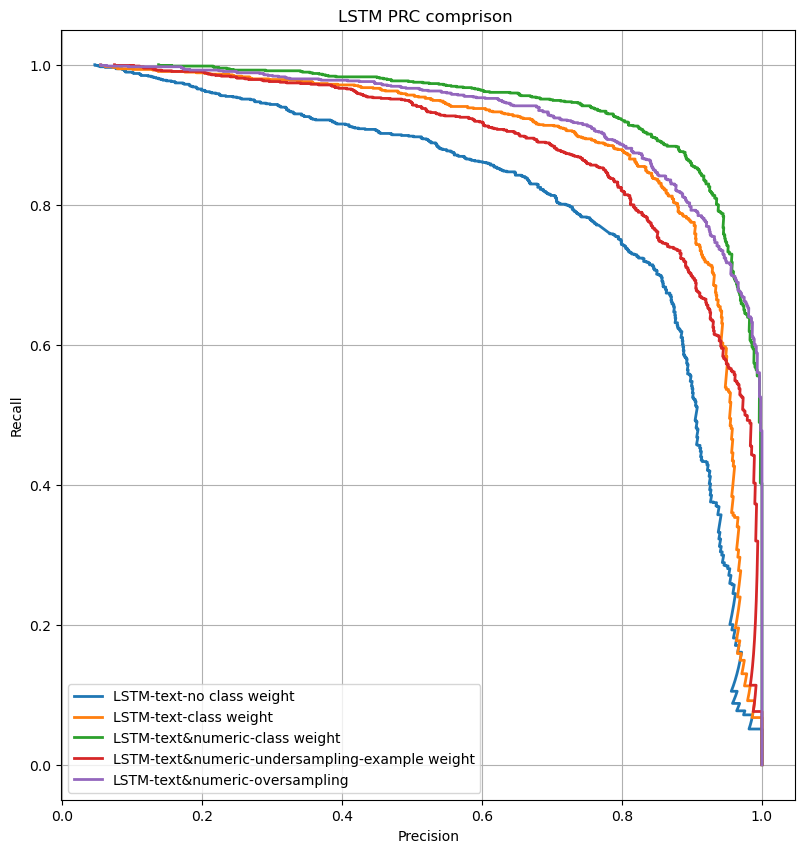

In [54]:
plot_prc("LSTM-text-no class weight", y_test, test_predictions_modelV0 )
plot_prc("LSTM-text-class weight", y_test, test_predictions_modelV1)
plot_prc("LSTM-text&numeric-class weight", y_test, test_predictions_modelV2)
plot_prc("LSTM-text&numeric-undersampling-example weight", y_test, test_predictions_modelV4)
plot_prc("LSTM-text&numeric-oversampling", y_test, test_predictions_modelV6)

plt.legend(loc='lower left');
plt.title('LSTM PRC comprison ')
plt.show()

### modelV7--oversampling with class weight

In [59]:
optimizer = Adam(learning_rate=0.01)
modelV7= LSTM_model(optimizer=optimizer, X_text_train=X_vect_train_over, X_num_train=X_train_over_num)
print(modelV7.summary())

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 500, 100)     5000000     ['input_5[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 500, 100)    0           ['embedding_2[0][0]']            
 opout1D)                                                                                   

In [62]:
optimizer = Adam(learning_rate=0.01)
modelV7= LSTM_model(optimizer=optimizer, X_text_train=X_vect_train_over, X_num_train=X_train_over_num)
print(modelV7.summary())
CALLBACKS=[EarlyStopping(monitor='val_prc', verbose=1,patience=3, mode='max',restore_best_weights=True)]
CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}
historyV7 = modelV7.fit(
    x=[X_vect_train_over, X_train_over_num],
    y=y_train_over, 
    validation_data=([X_vect_val, X_val_num],y_val),
    batch_size=32,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT,
    callbacks=CALLBACKS)

Epoch 1/20
10503/10503 [==============================] - 273s 26ms/step - loss: 5.2269e-07 - tp: 167937.0000 - fp: 8104.0000 - tn: 159935.0000 - fn: 102.0000 - accuracy: 0.9756 - precision: 0.9540 - recall: 0.9994 - auc: 0.9945 - prc: 0.9895 - val_loss: 0.0910 - val_tp: 1723.0000 - val_fp: 867.0000 - val_tn: 41188.0000 - val_fn: 89.0000 - val_accuracy: 0.9782 - val_precision: 0.6653 - val_recall: 0.9509 - val_auc: 0.9841 - val_prc: 0.8446
Epoch 2/20
10503/10503 [==============================] - 269s 26ms/step - loss: 2.6529e-07 - tp: 168007.0000 - fp: 3837.0000 - tn: 164202.0000 - fn: 32.0000 - accuracy: 0.9885 - precision: 0.9777 - recall: 0.9998 - auc: 0.9968 - prc: 0.9937 - val_loss: 0.0759 - val_tp: 1711.0000 - val_fp: 710.0000 - val_tn: 41345.0000 - val_fn: 101.0000 - val_accuracy: 0.9815 - val_precision: 0.7067 - val_recall: 0.9443 - val_auc: 0.9828 - val_prc: 0.8718
Epoch 3/20
10503/10503 [==============================] - 266s 25ms/step - loss: 2.0565e-07 - tp: 168010.0000 - 

In [64]:
modelV7.save('LSTM_model_V7_oversampling_class_weight.h5')

In [63]:
test_predictions_modelV7 = modelV7.predict([X_vect_test, X_test_num], batch_size=32)
predict_classes_V7=(test_predictions_modelV7 > 0.5).astype("int32")
print("ModelV7 Classification report:\n\n{}".format(classification_report(y_test, predict_classes_V7)))

762/762 [==============================] - 7s 9ms/step
ModelV7 Classification report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     23332
           1       0.72      0.95      0.82      1039

    accuracy                           0.98     24371
   macro avg       0.86      0.97      0.90     24371
weighted avg       0.99      0.98      0.98     24371



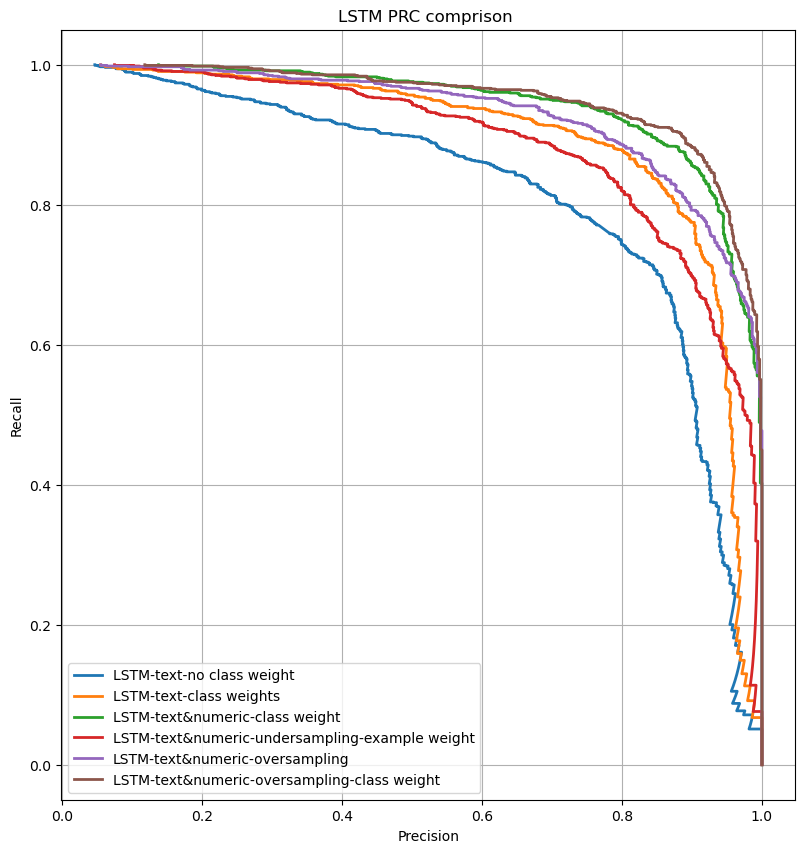

In [65]:
plot_prc("LSTM-text-no class weight", y_test, test_predictions_modelV0 )
plot_prc("LSTM-text-class weights", y_test, test_predictions_modelV1)
plot_prc("LSTM-text&numeric-class weight", y_test, test_predictions_modelV2)
plot_prc("LSTM-text&numeric-undersampling-example weight", y_test, test_predictions_modelV4)
plot_prc("LSTM-text&numeric-oversampling", y_test, test_predictions_modelV6)
plot_prc("LSTM-text&numeric-oversampling-class weight", y_test, test_predictions_modelV7)

plt.legend(loc='lower left');
plt.title('LSTM PRC comprison ')
plt.show()

### try GloVe 

In [ ]:
# MAX_SEQUENCE_LENGTH =500

# Tokenize and sequence training data
X_text_train_sequences = tokenizer.texts_to_sequences(X_train_text)
# Use pad_sequences to transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps)
X_text_train_padded = pad_sequences(X_text_train_sequences,maxlen=MAX_SEQUENCE_LENGTH)
                    
# Tokenize and sequence validation data                   
X_text_val_sequences = tokenizer.texts_to_sequences(X_val_text)
# pad_sequences for validation set
X_text_val_padded = pad_sequences(X_text_val_sequences,maxlen=MAX_SEQUENCE_LENGTH)

# Tokenize and sequence test data                   
X_text_test_sequences = tokenizer.texts_to_sequences(X_test_text)
# pad_sequences for test set
X_text_test_padded = pad_sequences(X_text_test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [66]:
# Here we are using the 100 Dimensional embedding of GloVe  
embeddings_index = {}
with open('/kaggle/input/glovefile/glove.6B/glove.6B.300d.txt') as f:
    for line in f:       
        values = line.split()       
        word = values[0]       
        coefs = np.asarray(values[1:], dtype='float32') 
        embeddings_index[word] = coefs   

# Creating embedding matrix for each word in Our corpus
embedding_matrix = np.zeros((len(word_index) + 1, 300))   
for word, i in word_index.items():    
    embedding_vector = embeddings_index.get(word)   
    if embedding_vector is not None:   
       # words not found in the embedding index will be all-zeros.  
       embedding_matrix[i] = embedding_vector

In [67]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13292   ,  0.16985001, -0.1436    , ..., -0.23778   ,
         0.14766   ,  0.62901998],
       [ 0.038466  , -0.039792  ,  0.082747  , ..., -0.33427   ,
         0.011807  ,  0.059703  ],
       ...,
       [ 0.68597001, -0.19038001,  0.063506  , ...,  0.31794   ,
         0.081171  , -0.33616   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### modelV8-GloVe with class weights

In [68]:
def GloVe_model(optimizer, x_num_train):
    # Define the text flow
    embedding_layer = Embedding(
    len(word_index) + 1,
    300,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False)

    input_text = keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int64")
    embedded_sequences = embedding_layer(input_text)
    x=SpatialDropout1D(0.2)(embedded_sequences)
    x = layers.LSTM(100, dropout=0.2, recurrent_dropout=0)(x)  
    x = Model(inputs=input_text, outputs=x)

    # Define the num flow
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(x_num_train)
    input_num = layers.Input(shape=(5,))
    y = normalizer(input_num)
    y = layers.Dense(10, activation="relu")(y)
    y = Model(inputs=input_num, outputs=y)   

    # Concatenate the two streams together
    combined = layers.concatenate([x.output, y.output])

    # Define joined Feed-Forward Layer
    z = layers.Dense(4, activation="relu")(combined)

    # Define output node of 1 
    z = layers.Dense(1, activation="sigmoid")(z)

    # Define the final model
    model=Model(inputs=[x.input, y.input], outputs=z)
    
    model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)
    return model

In [69]:
modelV8= GloVe_model(optimizer=Adam(learning_rate=0.01), x_num_train=X_train_num)
print(modelV8.summary())

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 500, 300)     47490300    ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 spatial_dropout1d_3 (SpatialDr  (None, 500, 300)    0           ['embedding_3[0][0]']            
 opout1D)                                                                                  

In [71]:
historyV8 = modelV8.fit(x=[X_vect_train, X_train_num],
             y=y_train,
             validation_data=([X_vect_val, X_val_num],y_val), 
             epochs=EPOCHS,verbose=1,
             class_weight=CLASS_WEIGHT,
             callbacks=CALLBACKS, batch_size=32)

#historyV8 = modelV8.fit(x=[X_text_train_padded, X_train_num],
#              y=y_train,
#              validation_data=([X_text_val_padded, X_val_num],y_val), 
#              epochs=EPOCHS,verbose=1,
#              class_weight=CLASS_WEIGHT,
#              callbacks=CALLBACKS, batch_size=32)

Epoch 1/20
5484/5484 [==============================] - 199s 28ms/step - loss: 2.8209e-06 - tp: 8195.0000 - fp: 30738.0000 - tn: 179356.0000 - fn: 1042.0000 - accuracy: 0.8551 - precision: 0.2105 - recall: 0.8872 - auc: 0.9410 - prc: 0.6156 - val_loss: 0.1384 - val_tp: 1658.0000 - val_fp: 1721.0000 - val_tn: 40334.0000 - val_fn: 154.0000 - val_accuracy: 0.9573 - val_precision: 0.4907 - val_recall: 0.9150 - val_auc: 0.9831 - val_prc: 0.8482
Epoch 2/20
5484/5484 [==============================] - 155s 28ms/step - loss: 1.3277e-06 - tp: 6931.0000 - fp: 9587.0000 - tn: 158452.0000 - fn: 494.0000 - accuracy: 0.9425 - precision: 0.4196 - recall: 0.9335 - auc: 0.9834 - prc: 0.8432 - val_loss: 0.1602 - val_tp: 1746.0000 - val_fp: 2485.0000 - val_tn: 39570.0000 - val_fn: 66.0000 - val_accuracy: 0.9418 - val_precision: 0.4127 - val_recall: 0.9636 - val_auc: 0.9896 - val_prc: 0.8867
Epoch 3/20
5484/5484 [==============================] - 155s 28ms/step - loss: 1.1730e-06 - tp: 6975.0000 - fp: 781

In [72]:
modelV8.save('LSTM_model_V8_Gloev.h5')

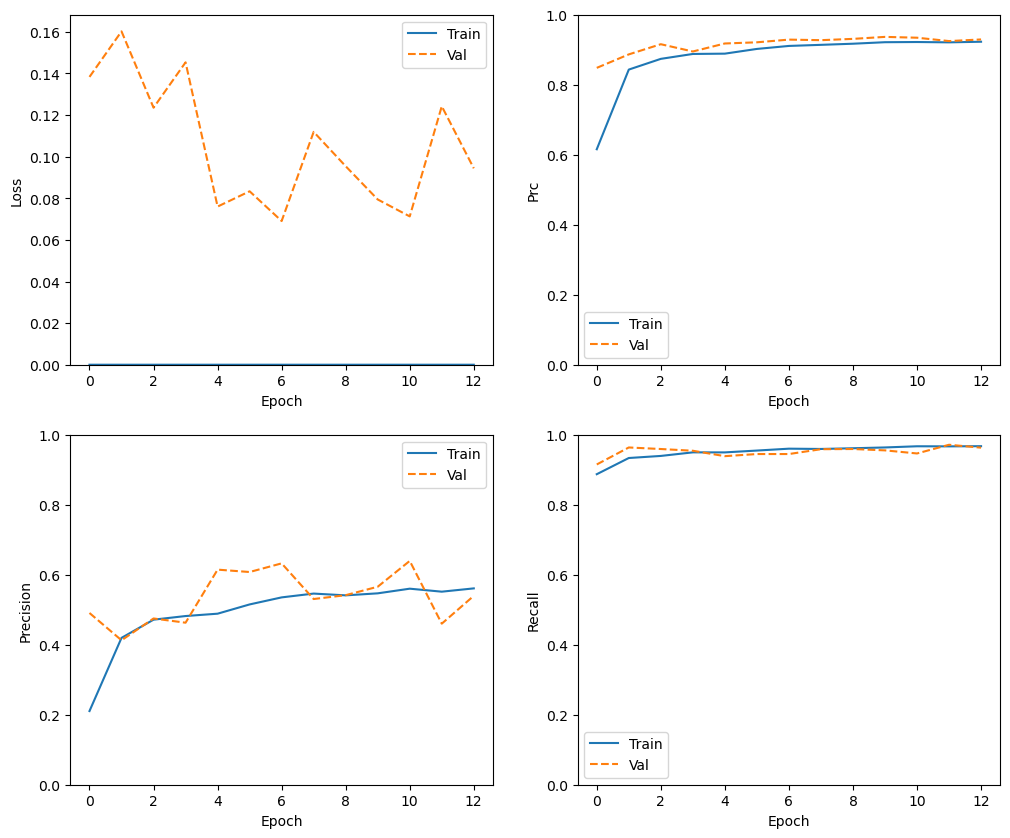

In [73]:
plot_metrics(historyV8)

In [75]:
test_predictions_modelV8 =  modelV8.predict([X_vect_test, X_test_num], batch_size=32)
predict_classes_V8=(test_predictions_modelV8 > 0.5).astype("int32")
print("modelV8 Classification report:\n\n{}".format(classification_report(y_test, predict_classes_V8)))

762/762 [==============================] - 7s 9ms/step
modelV8 Classification report:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     23332
           1       0.58      0.97      0.72      1039

    accuracy                           0.97     24371
   macro avg       0.79      0.97      0.85     24371
weighted avg       0.98      0.97      0.97     24371



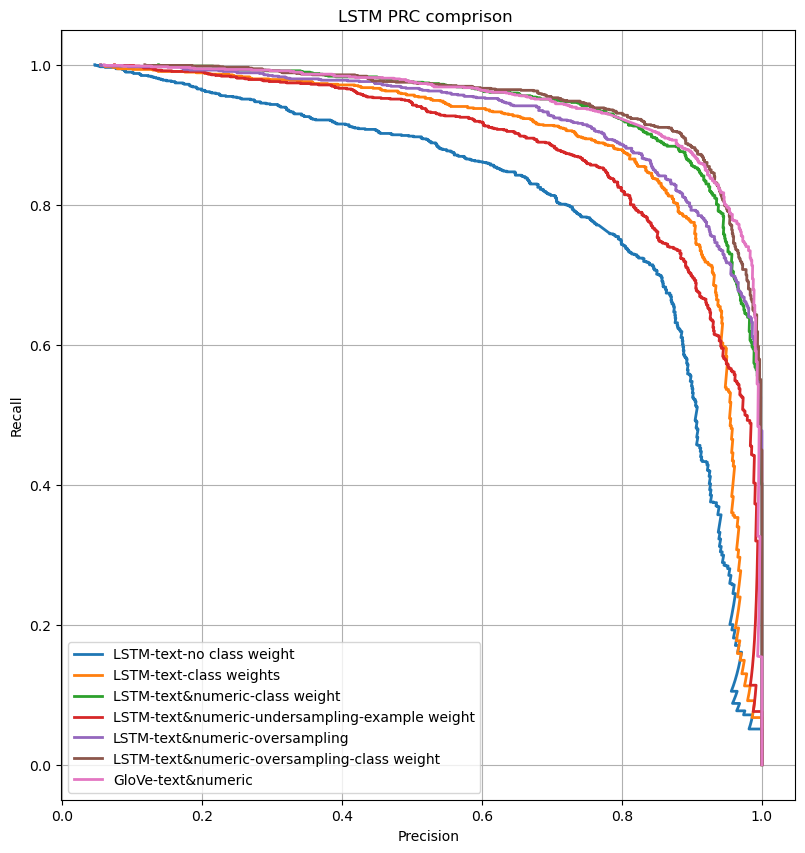

In [77]:
plot_prc("LSTM-text-no class weight", y_test, test_predictions_modelV0 )
plot_prc("LSTM-text-class weights", y_test, test_predictions_modelV1)
plot_prc("LSTM-text&numeric-class weight", y_test, test_predictions_modelV2)
plot_prc("LSTM-text&numeric-undersampling-example weight", y_test, test_predictions_modelV4)
plot_prc("LSTM-text&numeric-oversampling", y_test, test_predictions_modelV6)
plot_prc("LSTM-text&numeric-oversampling-class weight", y_test, test_predictions_modelV7)
plot_prc("GloVe-text&numeric", y_test, test_predictions_modelV8)
plt.legend(loc='lower left');
plt.title('LSTM PRC comprison ')
plt.show()

### modelV9-GloVe using oversampling method with class weights

In [ ]:
modelV9= GloVe_model(optimizer=Adam(learning_rate=0.01), x_num_train=X_train_over_num)
print(modelV8.summary())

CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}
historyV9 = modelV9.fit(
    x=[X_vect_train_over, X_train_over_num],
    y=y_train_over, 
    validation_data=([X_vect_val, X_val_num],y_val),
    batch_size=32,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT,
    callbacks=CALLBACKS)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 500, 300)     47490300    ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 spatial_dropout1d_3 (SpatialDr  (None, 500, 300)    0           ['embedding_3[0][0]']            
 opout1D)                                                                                  